In [1]:
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install wandb
%pip install tensorflow
%pip install pandas
%pip install natsort


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [1]:
from seqRESNET_BVPRN_model import ResNetFeatureExtractor, CNNLSTMWithBVP
from seqRESNET_BVPRN_training import train_and_validate_windowed_ubfc
from seqRESNET_BVPRN_test import test_model
from GradCAM import GradCAM, visualize_gradcam
from NegPearCor import NegativePearsonCorrelation
from CNN_dataset import WindowedUBFCPhysDataset
# from CNN_dataset_augmented import WindowedUBFCPhysDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import os
import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wandb


### Data loading and training

In [ ]:
train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Train_norm"
test_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Test_norm"
val_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Validation_norm"


num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0001
window_size = 20
stride = 15
batch_size = 32

train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
                                        window_size=window_size,
                                        stride=stride)
val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
                                        window_size=window_size,
                                        stride=stride)
test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
                                        window_size=window_size,
                                        stride=stride)


# needed when CNN_dataset_augmented is used
# train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
#                                         window_size=window_size,
#                                         stride=stride,p=0.7, isTrain=True)
# val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
#                                         window_size=window_size,
#                                         stride=stride,p=0.0 isTrain=False)
# test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
#                                         window_size=window_size,
#                                         stride=stride,p=0.0 isTrain=False)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb.init(project="CNN+BVP+RN_norm", entity="aml-final-project")


cnn_feature_extractor = ResNetFeatureExtractor()
model = CNNLSTMWithBVP(
    feature_extractor=cnn_feature_extractor, 
    hidden_size=256, 
    bvp_embed_size=32
)

criterion = nn.MSELoss()
# criterion = NegativePearsonCorrelation()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_losses, val_losses, first_epoch_preds, last_epoch_preds = train_and_validate_windowed_ubfc(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device
)


/home/ucloud/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work/AML_Project/5_Models/CNN_dataset.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#unt

[Epoch 1/2] Train Loss: 0.0136
           Validation Loss: 0.0982
[Epoch 2/2] Train Loss: 0.0118
           Validation Loss: 0.1099


Epoch,▁█
Train Loss,█▁
Validation Loss,▁█
Epoch,2
Train Loss,0.01175
Validation Loss,0.1099


### Train & validation plots

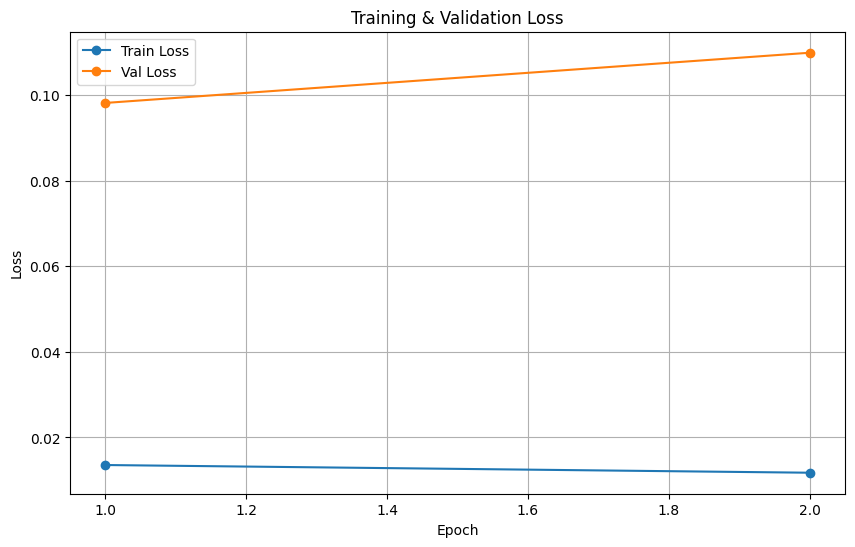

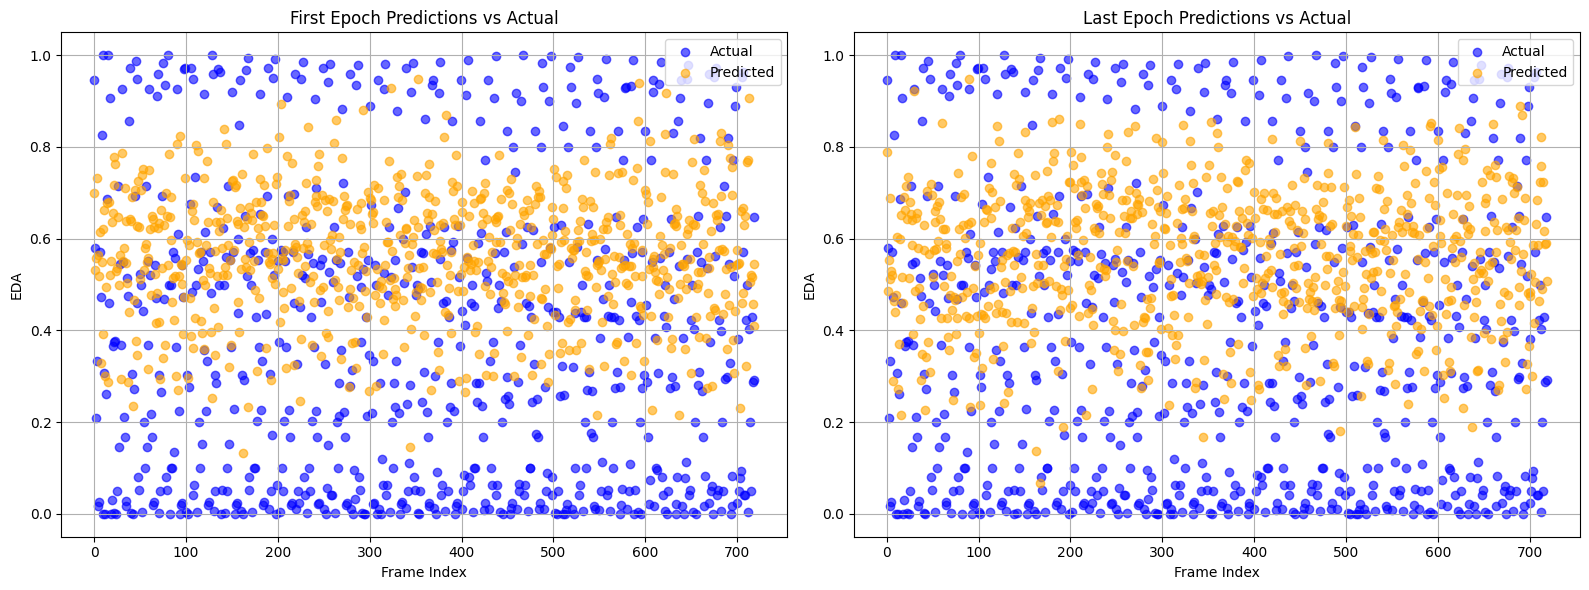

In [6]:
def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Val Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, val_losses)

import matplotlib.pyplot as plt

def plot_predictions_vs_actuals(y_true_first, y_pred_first, y_true_last, y_pred_last, max_frames=100):
    
    max_frames = min(max_frames, len(y_true_first), len(y_pred_first),
                     len(y_true_last), len(y_pred_last))
    
    
    y_true_first_limited = y_true_first[:max_frames]
    y_pred_first_limited = y_pred_first[:max_frames]
    y_true_last_limited = y_true_last[:max_frames]
    y_pred_last_limited = y_pred_last[:max_frames]
    
    
    plt.figure(figsize=(16, 6))
    
    
    plt.subplot(1, 2, 1)
    plt.scatter(range(max_frames), y_true_first_limited, color='blue', alpha=0.6, label='Actual')
    plt.scatter(range(max_frames), y_pred_first_limited, color='orange', alpha=0.6, label='Predicted')
    plt.title("First Epoch Predictions vs Actual")
    plt.xlabel("Frame Index")
    plt.ylabel("EDA")
    plt.legend()
    plt.grid(True)
    
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(max_frames), y_true_last_limited, color='blue', alpha=0.6, label='Actual')
    plt.scatter(range(max_frames), y_pred_last_limited, color='orange', alpha=0.6, label='Predicted')
    plt.title("Last Epoch Predictions vs Actual")
    plt.xlabel("Frame Index")
    plt.ylabel("EDA")
    plt.legend()
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()


plot_predictions_vs_actuals(
    first_epoch_preds["true"], 
    first_epoch_preds["pred"], 
    last_epoch_preds["true"], 
    last_epoch_preds["pred"],
    max_frames=720  
)


### Test loss

In [12]:
test_loss, y_true, y_pred = test_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0424
